# Analysis of Batch Size Impact on GPT Evaluations

This notebook analyzes how the batch size of tasks affects the correlation between GPT-4 evaluations and human quiz responses.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from gpt_grader import evaluate_groupings_gpt

# Read and process the quiz responses
df = pd.read_csv('./GS_responses.csv')
df = df.iloc[:, 1:]  # Remove the first column
question_columns = df.columns[1:]

# Calculate quiz_vector (average response for each question)
quiz_vector = df[question_columns].mean().values
print(f"Quiz vector shape: {quiz_vector.shape}")

Quiz vector shape: (25,)


In [6]:
quiz_vector

array([3.41509434, 2.03773585, 3.35849057, 1.86792453, 3.30188679,
       2.54716981, 2.39622642, 2.43396226, 2.94339623, 2.26415094,
       2.11320755, 1.73584906, 2.88679245, 2.49056604, 3.11320755,
       2.83018868, 1.88679245, 2.77358491, 2.13207547, 2.79245283,
       3.03773585, 2.49056604, 3.0754717 , 3.35849057, 2.75471698])

In [2]:
# Define the tasks based on the questions in the quiz
tasks = [
    # Blood Pressure tasks
    ("Blood pressure (mmHg)", [(float('-inf'), 120), (120, 129), (130, 139), (140, float('inf'))], (0, float('inf'))),
    ("Blood pressure (mmHg)", [(float('-inf'), 120), (120, float('inf'))], (0, float('inf'))),
    
    # BMI tasks
    ("Body Mass Index (BMI)", [(float('-inf'), 18.5), (18.5, 24.9), (25, 29.9), (30, float('inf'))], (10, 50)),
    ("Body Mass Index (BMI)", [(float('-inf'), 5), (5, 15), (15, float('inf'))], (10, 50)),
    
    # AQI tasks
    ("Air Quality Index (AQI)", [(0, 50), (51, 100), (101, 150), (151, 200), (201, 300), (301, float('inf'))], (0, float('inf'))),
    ("Air Quality Index (AQI)", [(0, 60), (61, 120), (121, 180), (181, 240), (241, 300), (301, 500)], (0, float('inf'))),
    ("Air Quality Index (AQI)", [(0, 40), (41, 80), (81, 120), (121, 300), (301, 500)], (0, float('inf'))),
    ("Air Quality Index (AQI)", [(0, 75), (76, 150), (151, 225), (226, 300), (301, 375), (376, 450), (451, float('inf'))], (0, float('inf'))),
    ("Air Quality Index (AQI)", [(0, 50), (51, 100), (101, 200), (201, 300), (301, float('inf'))], (0, float('inf'))),
    
    # Temperature tasks
    ("Temperature", [(float('-inf'), 0), (1, 99), (100, float('inf'))], (-200, 500)),
    ("Temperature", [(float('-inf'), 5), (5, 25), (25, float('inf'))], (-200, 500)),
    ("Temperature", [(float('-inf'), 3), (3, float('inf'))], (-200, 500)),
    ("Temperature", [(float('-inf'), -100), (-100, 0), (1, 100), (101, 200), (201, 300)], (-200, 500)),
    ("Temperature", [(float('-inf'), 10), (10, 15), (15, 20), (20, 25), (25, 30), (30, float('inf'))], (-200, 500)),
    
    # Body Temperature tasks
    ("Body temperature", [(float('-inf'), 36.1), (36.1, 37.5), (37.5, float('inf'))], (35, 42)),
    ("Body temperature", [(35, 37), (37, 39), (39, 41), (41, float('inf'))], (35, 42)),
    
    # GNI per capita tasks
    ("GNI per capita (1,000 USD)", [(float('-inf'), 5), (5, float('inf'))], (0, float('inf'))),
    ("GNI per capita (1,000 USD)", [(float('-inf'), 1), (1, 4), (4, 7), (7, 10), (10, float('inf'))], (0, float('inf'))),
    ("GNI per capita (1,000 USD)", [(float('-inf'), 4.515), (4.515, float('inf'))], (0, float('inf'))),
    ("GNI per capita (1,000 USD)", [(float('-inf'), 1.145), (1.146, 4.515), (4.516, 14.005), (14.005, float('inf'))], (0, float('inf'))),
    
    # Movie Ratings tasks
    ("Movie Ratings (IMDb)", [(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10)], (0, 10)),
    ("Movie Ratings (IMDb)", [(0, 7), (7, float('inf'))], (0, 10)),
    ("Movie Ratings (IMDb)", [(float('-inf'), 4), (4, 7), (7, 9), (9, float('inf'))], (0, 10)),
    
    # Heart Rate tasks
    ("Heart Rate (Percentage of HRmax)", [(50, 60), (60, 70), (70, 80), (80, 90), (90, 100)], (50, 100)),
    ("Heart Rate (Percentage of HRmax)", [(50, 85), (85, 100)], (50, 100))
]

print(f"Number of tasks: {len(tasks)}")

Number of tasks: 25


In [ ]:
# Function to split tasks into batches
def split_into_batches(tasks, batch_size):
    return [tasks[i:i + batch_size] for i in range(0, len(tasks), batch_size)]

# Initialize results DataFrame
results_df = pd.DataFrame(columns=['batch_size', 'correlation', 'p_value'])

# Test different batch sizes
for batch_size in [1,2,3,4,5,6,7,8]:
    print(f"\nProcessing batch size: {batch_size}")
    
    # Split tasks into batches
    batches = split_into_batches(tasks, batch_size)
    
    # Collect all GPT grades
    gpt_grades = []
    
    # Process each batch
    for batch in batches:
        try:
            batch_results = evaluate_groupings_gpt(batch)
            print(batch_results)
            gpt_grades.extend([result[0] for result in batch_results])  # Extract grades
        except Exception as e:
            print(f"Error processing batch: {e}")
            continue
    
    # Calculate correlation if we have all grades
    if len(gpt_grades) == len(tasks):
        correlation, p_value = spearmanr(gpt_grades, quiz_vector)
        
        # Add to results DataFrame
        results_df = pd.concat([results_df, pd.DataFrame({
            'batch_size': [batch_size],
            'correlation': [correlation], 
            'p_value': [p_value]
        })], ignore_index=True)
        
        print(f"Correlation: {correlation:.4f}, p-value: {p_value:.4f}")

print("\nResults DataFrame:")
print(results_df)


Processing batch size: 1
Correlation: 0.6038, p-value: 0.0014

Processing batch size: 2
Correlation: 0.6880, p-value: 0.0001

Processing batch size: 3
Correlation: 0.6312, p-value: 0.0007

Processing batch size: 4
Correlation: 0.7921, p-value: 0.0000

Processing batch size: 5
Correlation: 0.7831, p-value: 0.0000

Processing batch size: 6
Correlation: 0.7729, p-value: 0.0000

Processing batch size: 7
Correlation: 0.7705, p-value: 0.0000

Processing batch size: 8
Correlation: 0.7965, p-value: 0.0000

Results DataFrame:
  batch_size  correlation   p_value
0          1     0.603830  0.001393
1          2     0.688004  0.000144
2          3     0.631210  0.000716
3          4     0.792070  0.000002
4          5     0.783128  0.000004
5          6     0.772916  0.000006
6          7     0.770522  0.000007
7          8     0.796461  0.000002


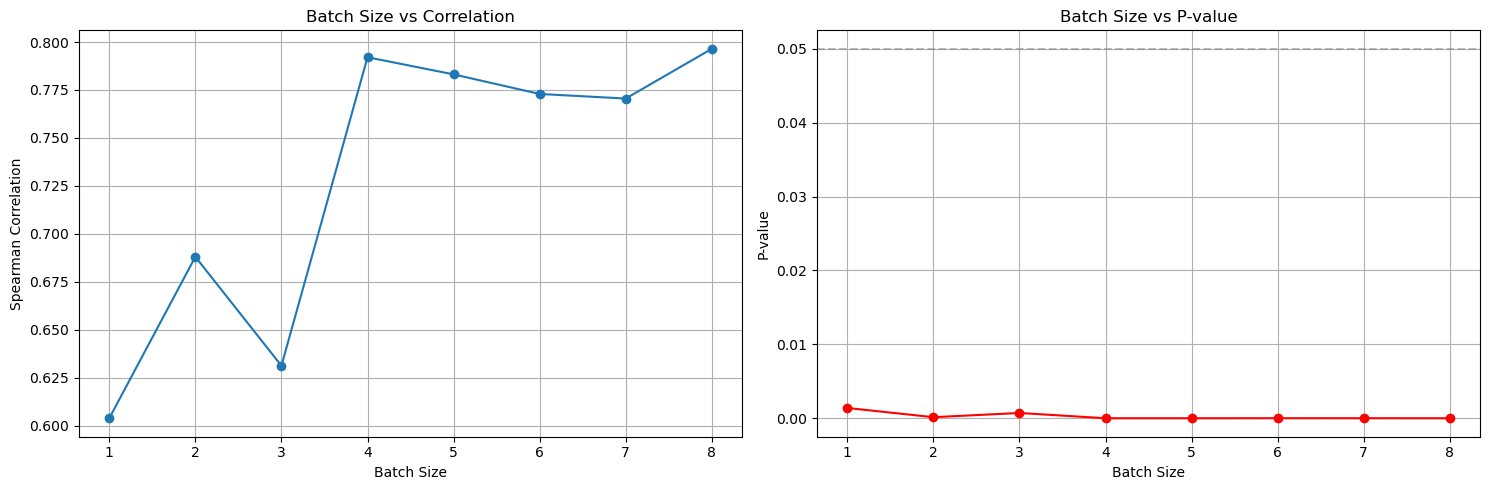

In [5]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot correlation values
ax1.plot(results_df['batch_size'], results_df['correlation'], marker='o')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Spearman Correlation')
ax1.set_title('Batch Size vs Correlation')
ax1.grid(True)

# Plot p-values
ax2.plot(results_df['batch_size'], results_df['p_value'], marker='o', color='red')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('P-value')
ax2.set_title('Batch Size vs P-value')
ax2.grid(True)

# Add horizontal line at p=0.05 for reference
ax2.axhline(y=0.05, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()